In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pywt
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_absolute_error,mean_squared_error ,r2_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import euclidean_distances
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
data=pd.read_csv("Data_BestStock.csv")
df = pd.DataFrame(data)
df=df.drop('index',axis=1)

In [3]:
##feauter selection
#drop 8 , 9 , 10 for 0.98 coorolation
df.drop(columns=['8','9','10','11','final','open'], inplace=True)

In [4]:
#define return column
prev=df['close'].shift(1)
ret=(df['close']-prev)/prev
ret=ret.fillna(method='bfill')
df['return']=ret


In [5]:
def normalize_data(df,forbiden):
    for col in df.columns :
        if col not in forbiden :
            if df[col].dtype == 'int64' or df[col].dtype == 'float64':
                if (df[col] <0).any() or (df[col]>1).any():
                    min_max=preprocessing.MinMaxScaler()
                    df[col]=min_max.fit_transform(df[col].values.reshape(-1,1))
                    
    return df
    

In [6]:
df=normalize_data(df,['target','date_time','index'])

In [7]:
def to_datetime():
    date=df['date_time']
    import datetime
    date=date.astype(str)

    for i in range (len(date)):
    #print (date[i])
        date[i]=datetime.datetime(int(date[i][:4]),int(date[i][4:6]),int(date[i][6:]))
    #print (date[i])
    df['date_time']=date

In [8]:
to_datetime()

In [9]:
X=df.drop(['date_time','target'],axis=1)
Y=df['target']


In [10]:
# Define the function to return the SMAPE value
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )
  
def evalute(y_true,y_predict):
    mse="MSE is  : {0}".format(mean_squared_error(y_true,y_predict))
    mae="MAE is : {0}".format(mean_absolute_error(y_true,y_predict))
    r2="R2 squre is : {0}".format(r2_score(y_true,y_predict))
    mSAMPE= "SMAPE is {0} %".format(calculate_smape(y_true,y_predict))
    total = mse +"\n"+mae+"\n"+r2+"\n"+mSAMPE
    return total

In [11]:

def plotting(y,y_pre,time):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    fig.subplots_adjust(top=0.85)
    ax.plot(sorted(time),y, mfc='green', mec='yellow',ms='7')
    ax.plot(sorted(time),y_pre)
    ax.set_title('axes title')
    ax.set_xlabel('xlabel')
    ax.set_ylabel('ylabel')
    ax.text(1.2, 0.2,evalute(y,y_pre) , horizontalalignment='center',
    verticalalignment='center', transform=ax.transAxes)
    ax.legend()

In [12]:
def find_point (target,X):
    dif=target.diff()
    
    points=[]
    Xt=df.loc[dif[dif == 0].index.values]
    for i in Xt.index:
        if i>0 and dif[i-1] !=0 and dif[i+1] ==0:
            train=X[:i]
            if len(train[train['ispotential']==1]) >1 :
                points.append(i)
            
        
    points.append(len(df))
        
    return points

In [13]:
pointt=find_point(Y,X)

In [14]:
pointt

[65,
 115,
 179,
 222,
 262,
 273,
 318,
 346,
 364,
 457,
 481,
 523,
 547,
 614,
 632,
 674,
 696,
 752,
 940,
 979,
 1080,
 1102,
 1129,
 1159,
 1181,
 1223,
 1276,
 1353,
 1407,
 1432,
 1455,
 1475,
 1514,
 1573,
 1632,
 1666,
 1676,
 1715,
 1756,
 1774,
 1805,
 1858,
 1899,
 1926,
 2022,
 2058,
 2075,
 2103,
 2176,
 2243,
 2260,
 2307,
 2318]

In [15]:

def split_data(ex):


    if pointt[ex]==0 :
        raise Exception("start must be bigger than zero")
      #return None
    #else:
    if ex == 0 :
        
        X_train=X[:pointt[ex]]
        Y_train=Y[:pointt[ex]]

    else :
        X_train=X[pointt[ex-1]:pointt[ex]]
        Y_train=Y[pointt[ex-1]:pointt[ex]]

  #else :
    #X_train=X[pointt[ex-1]:pointt[ex]]
    #Y_train=Y[pointt[ex-1]:pointt[ex]]
    X_test=X[pointt[ex]:pointt[ex+1]]
    Y_test=Y[pointt[ex]:pointt[ex+1]]



    return X_train,X_test,Y_train,Y_test
  #return (type(X_train))



In [16]:

def splitw_data(ex):


    if pointt[ex]==0 :
        raise Exception("start must be bigger than zero")
      #return None
    #else:
    
    #if ex == 0 :
        
    X_train=X[:pointt[ex]]
    Y_train=Y[:pointt[ex]]

  #else :
    #X_train=X[pointt[ex-1]:pointt[ex]]
    #Y_train=Y[pointt[ex-1]:pointt[ex]]
    X_test=X[pointt[ex]:pointt[ex+1]]
    Y_test=Y[pointt[ex]:pointt[ex+1]]



    return X_train,X_test,Y_train,Y_test
  #return (type(X_train))


In [17]:
df['linear']=0

In [18]:
from sklearn.metrics.pairwise import euclidean_distances
def sam(l):
    
    s=1/(1+euclidean_distances(l))
    we=s.sum(axis=0)
    we /= we.sum()
    return we

In [19]:
def run_line():
    df2=pd.DataFrame(columns=["predict","real","date_time"])

    model=Ridge(alpha=1.0,random_state = 0) 
    #model= RandomForestRegressor(n_estimators = 100, random_state = 0)
    for ex in range(len(pointt)-1):  
        X_train,X_test,Y_train,Y_test=splitw_data(ex)
    #X_train=X_train[['23','25','49','51','54','55']]
    #X_test=X_test[['23','25','49','51','54','55']]
    #model = LinearRegression()
    
        model.fit(X_train, Y_train,sample_weight=sam(X_train))
        y_predict = model.predict(X_test)

        data=[]
        



        for i in range(len(y_predict)):

            data.append({'predict':y_predict[i] , 'date_time':df['date_time'][X_test.index[i]],
                     "real":Y_test.values[i]})

        df2=df2.append(data,ignore_index=True)
    df['linear'].loc[:len(df)-len(df2)]=0
    df['linear'].loc[len(df)-len(df2):]=df2['predict'].values
  
    #df2.loc[Y_test[Y_test==0].index,'exit_real']=1
      

    return df2,model


In [20]:
y_l,rdige_model=run_line()


/home/atefeh/.local/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


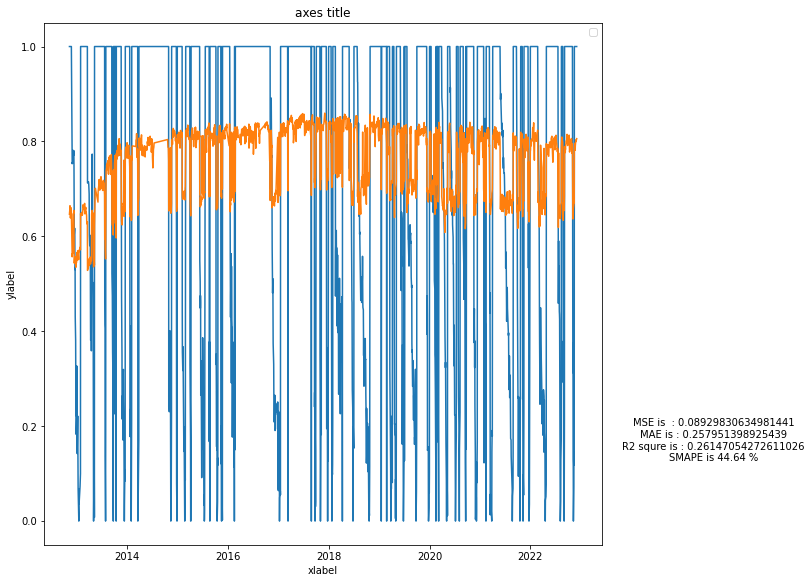

In [21]:
plotting(y_l['real'][:],y_l['predict'][:],y_l['date_time'][:])

# run wavlet mode

In [22]:
import copy
def filter_bank(index_list, wavefunc='haar', lv=4, m=1, n=4, plot=False):

   
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function# Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold why?
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold# Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)): #rconstruct by coffs
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        #data.plot(figsize=(10,10),subplots=(2,1))
        #data.plot(figsize=(10,5))
   
    return coeff

In [23]:
def replace_data(df,forbidden):
    cols=df.columns
    for col in cols :
        if col not in forbidden :
            composite_signal=df[col]
            coeff=filter_bank(composite_signal,plot=True)
            df[col]=coeff[0]
            
    return df

In [24]:
forbidden=['date_time','target','ispotential']
#forbidden=df.columns.drop(['linear','return','close']).to_numpy()
df=replace_data(df,forbidden)

In [25]:
X=df.drop(['date_time','target'],axis=1)
Y=df['target']


In [31]:
def run():
  df2=pd.DataFrame(columns=["predict","real","exit_pre","exit_real"])

  model_long= RandomForestRegressor(n_estimators = 100, random_state = 122)
  model_short=DecisionTreeRegressor(max_depth=5,random_state = 122)
  for ex in range(len(pointt)-1):  
    X_train,X_test,Y_train,Y_test=splitw_data(ex)
    X_train_sh,X_test,Y_train_sh,Y_test=split_data(ex)
    
    model_short=DecisionTreeRegressor(max_depth=5)
    model_long.fit(X_train, Y_train,sample_weight=sam(X_train))
    model_short.fit(X_train_sh, Y_train_sh)
    y_predict_long = model_long.predict(X_test)
    y_predict_short = model_short.predict(X_test)
    
    y_predict=((y_predict_long)+(y_predict_short))/2
    data=[]

    
    tar=Y_train
    idx=tar[tar==0].index
    dif=tar.diff()
    most_repeat=dif.loc[idx].value_counts().index[0]
    #print (most_repeat)
    for i in range(len(y_predict)):
        if (i >0 and np.floor(most_repeat+most_repeat*0.3*10)/10 <= y_predict[i] <= np.floor(most_repeat-most_repeat*0.3*10)/10 )or y_predict[i]==0 :
            pre=1
        else:
            pre=0
        data.append({'predict':y_predict[i] , 'date_time':df['date_time'][X_test.index[i]],
                     "real":Y_test.values[i],"exit_pre":pre,"exit_real":0})

    df2=df2.append(data,ignore_index=True)



  
    df2.loc[df2[df2['real']==0].index,'exit_real']=1
      

  return df2 ,model_short,model_long



In [32]:
y,model_short,model_short=run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


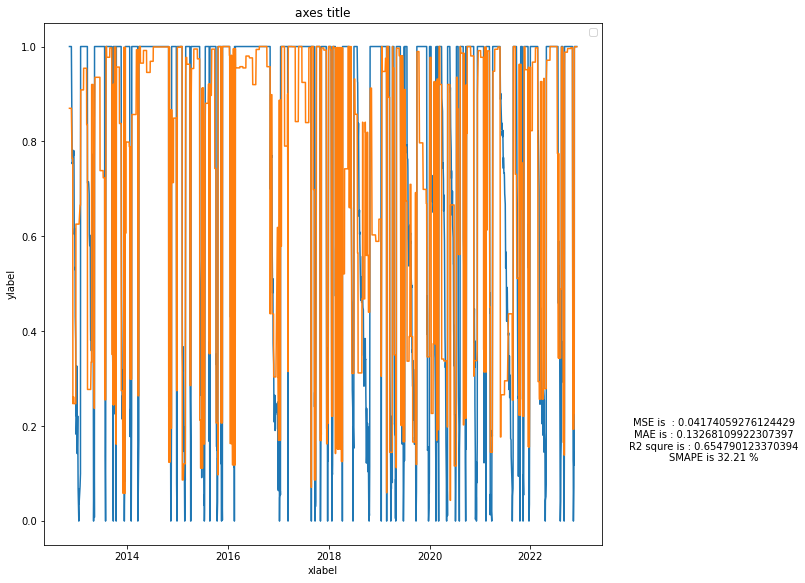

In [33]:
plotting(y['real'][:],y['predict'][:],y['date_time'][:])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


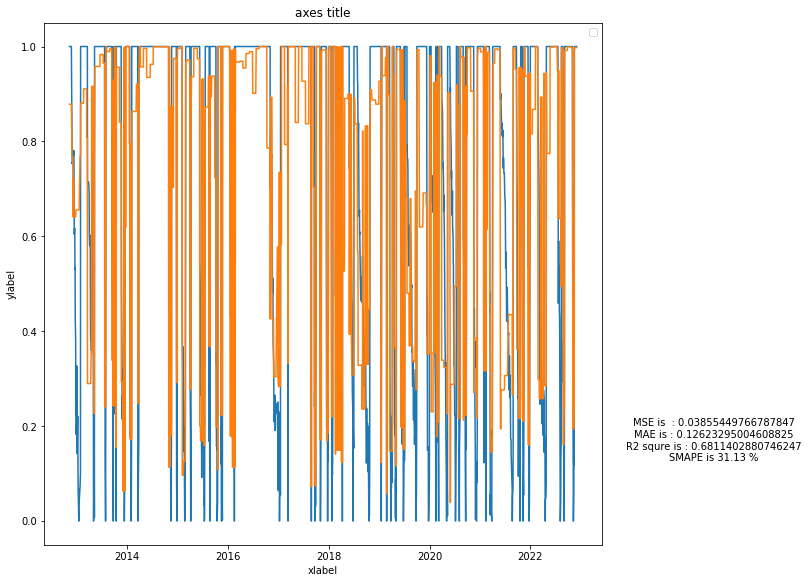

In [75]:
plotting(y['real'][:],y['predict'][:],y['date_time'][:])

In [1]:
print(len(y[y['exit_real']==1]))
print(len(y[y['exit_pre']==1]))
y[['exit_real','exit_pre']].plot()

NameError: name 'y' is not defined

In [72]:
y['date_time']=y['date_time'].astype("object")

In [78]:
len(y)

2253

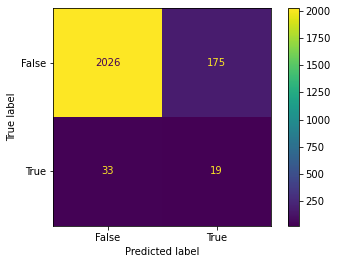

In [35]:
con_ma=confusion_matrix(y['exit_real'].astype(bool), y['exit_pre'].astype(bool)) 
cm_display = ConfusionMatrixDisplay(confusion_matrix = con_ma, display_labels = [False, True]) 
cm_display.plot()
plt.show()

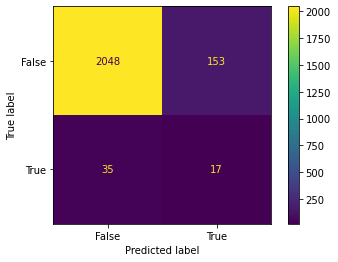

In [77]:
con_ma=confusion_matrix(y['exit_real'].astype(bool), y['exit_pre'].astype(bool)) 
cm_display = ConfusionMatrixDisplay(confusion_matrix = con_ma, display_labels = [False, True]) 
cm_display.plot()
plt.show()

In [40]:
df['exit']=np.nan
df['exit'].loc[len(df)-len(y):]=y['exit_pre'].values

In [29]:
y[(y['exit_real']==1) & (y['exit_pre']==1)]

,predict,real,exit_pre,exit_real,date_time
452,0.147552,0.0,1,1,2015-02-21
545,0.152154,0.0,1,1,2015-07-13
681,0.164604,0.0,1,1,2016-02-16
869,0.122613,0.0,1,1,2017-01-08
912,0.180999,0.0,1,1,2017-03-11
1013,0.165158,0.0,1,1,2017-08-27
1031,0.190585,0.0,1,1,2017-09-23
1058,0.198221,0.0,1,1,2017-11-01
1156,0.117934,0.0,1,1,2018-04-09
1365,0.110848,0.0,1,1,2019-02-24


In [67]:
corr_matrix = df.corr()

# Check the correlation between features
#print(corr_matrix)

# Drop feature_2 if its correlation with feature_1 is above a certain threshold
threshold = 0.3
feautres=df.columns.drop(['date_time','target'])
for fe in range(len(feautres)) :

    if np.abs(corr_matrix.loc['target',feautres[fe]]) > threshold :
    #df.drop(columns=['feature_2'], inplace=True)
      print (" feat {0} with target".format(feautres[fe],df['target']))


 feat 22 with target
 feat 23 with target
 feat 25 with target
 feat 26 with target
 feat 49 with target
 feat 51 with target
 feat 54 with target
 feat 55 with target
 feat ispotential with target
 feat return with target
 feat linear with target


In [41]:
df['exit']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2313      0
2314      0
2315      0
2316      0
2317      0
Name: exit, Length: 2318, dtype: object